У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, ARIMA, AutoARIMA, RNNModel 
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from pmdarima import auto_arima
from darts.metrics import rmse
from darts.metrics import mae as mae_metric, mape as mape_metric
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from darts.utils.statistics import plot_acf, check_seasonality
import itertools
import plotly.graph_objects as go
from functools import reduce

import warnings
print(warnings.__file__)

from utils import plot_forecasts, fit_eval_model, append_results, mae, mape, simple_grid_search

/home/liubov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


/usr/lib/python3.10/warnings.py


In [2]:
# 1. Load the data, convert date column to datetime, and set it as index.
df = pd.read_csv("train.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Display the first 10 rows and dataframe information
print(df.head(10))
print(df.info())

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



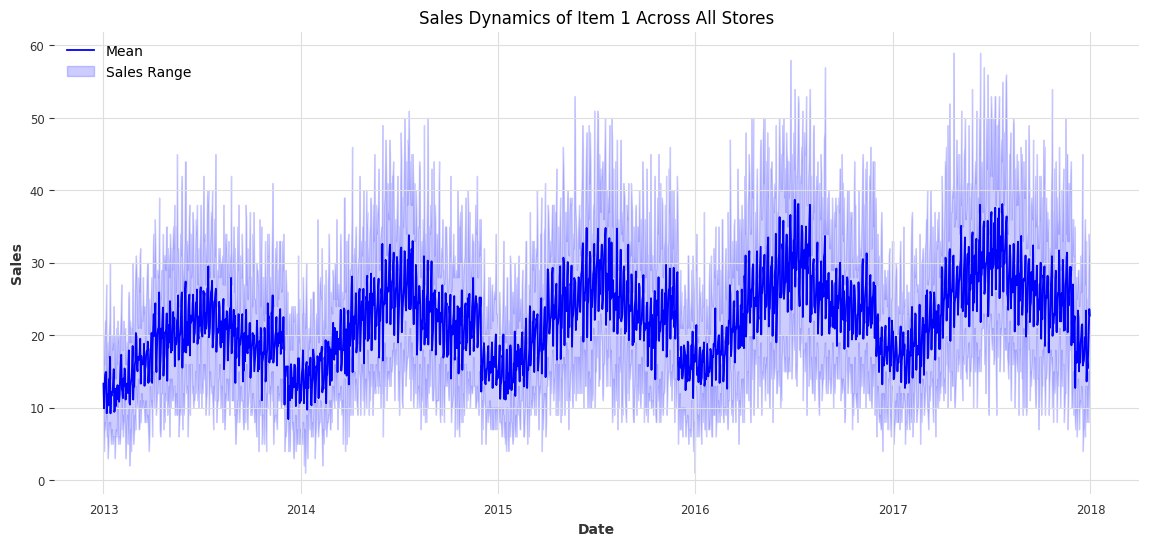

In [3]:
#  Average daily sales for one item across all stores
item_id = 1
df_item = df[df['item'] == item_id].groupby(['date']).agg(
    mean_sales=('sales', 'mean'),
    min_sales=('sales', 'min'),
    max_sales=('sales', 'max')
).reset_index()

plt.figure(figsize=(14,6))
plt.plot(df_item['date'], df_item['mean_sales'], label='Mean', color='blue')
plt.fill_between(df_item['date'], df_item['min_sales'], df_item['max_sales'], color='blue', alpha=0.2, label='Sales Range')
plt.title(f'Sales Dynamics of Item {item_id} Across All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

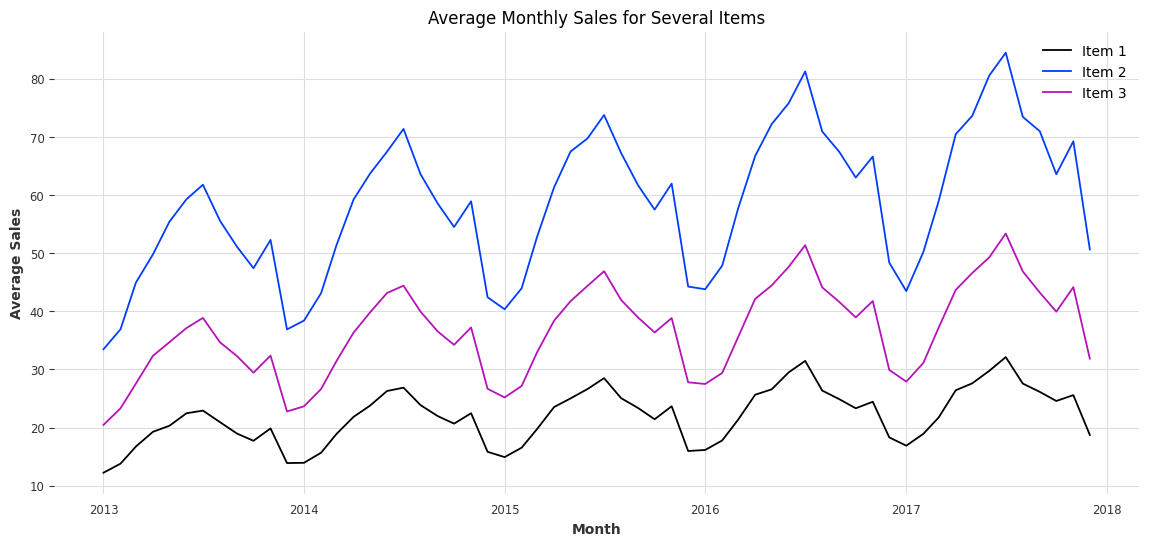

In [4]:
# 2. Average monthly sales for several items
df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.to_period('M')
selected_items = [1, 2, 3]  # example of three items
plt.figure(figsize=(14,6))
for item in selected_items:
    monthly_sales = df_monthly[df_monthly['item'] == item].groupby('month')['sales'].mean()
    plt.plot(monthly_sales.index.to_timestamp(), monthly_sales.values, label=f'Item {item}')
plt.title('Average Monthly Sales for Several Items')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.legend()
plt.show()

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [5]:
subset = df[(df['store'] == 1) & (df['item'] == 1)].copy()

In [6]:
result = seasonal_decompose(subset['sales'], model='additive', period=7)  # period=7 days

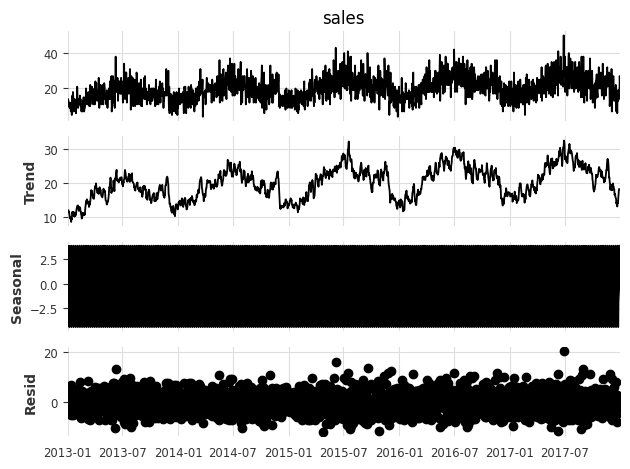

In [7]:
result.plot()
plt.show()

Insight:

- Trend: gradual rises and falls.

- Seasonality: weekly signals (7-day, 14-day, 21-day cycles) detected.

- Residuals: occasional spikes >> outliers or special events.

4. Зі створеної підмножини даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [ ]:
series_sales = TimeSeries.from_dataframe(subset, value_cols='sales')

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [9]:
series_sales = series_sales.astype(float)  
val_start = pd.Timestamp('2017-10-01')
train, val = series_sales.split_before(val_start)

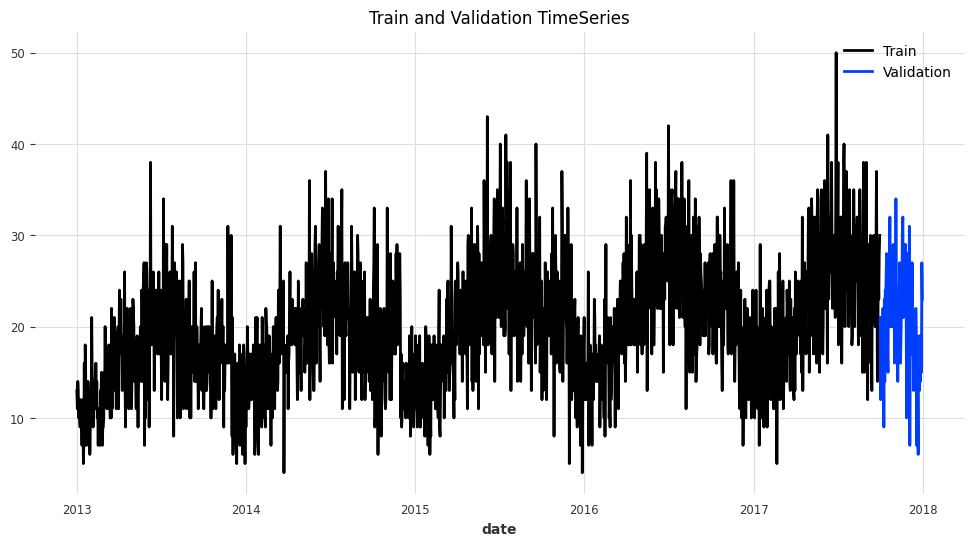

In [10]:
plt.figure(figsize=(12,6))
train.plot(label='Train')
val.plot(label='Validation')
plt.title('Train and Validation TimeSeries')
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

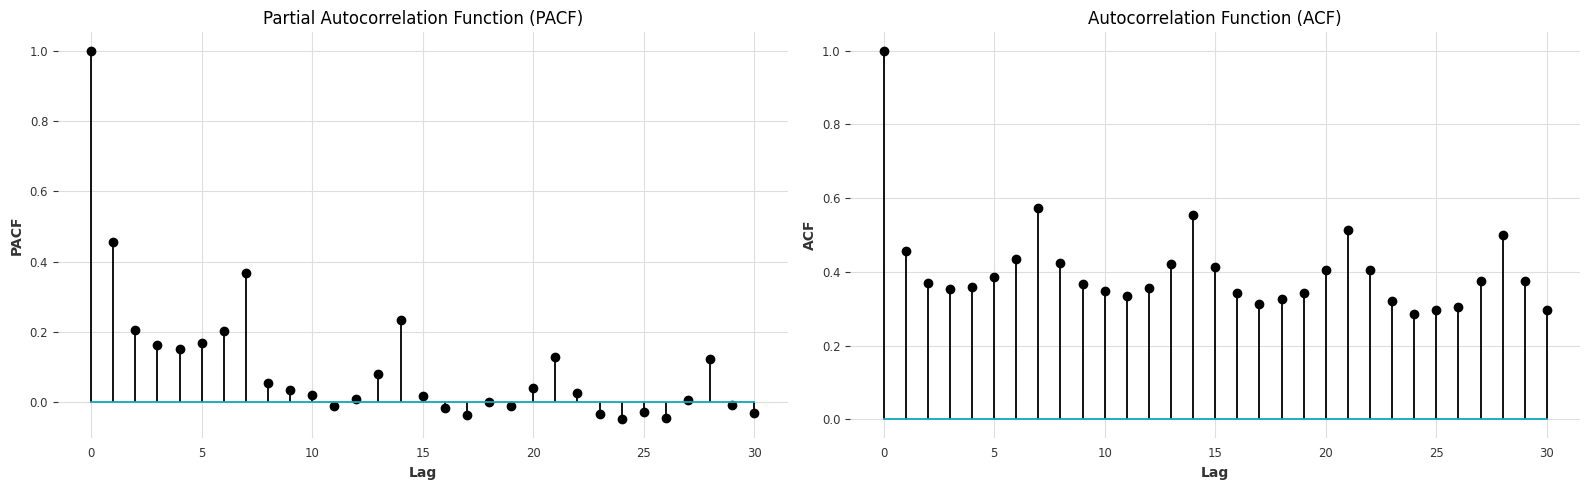

In [11]:
train_values = train.values().flatten()

# Compute ACF and PACF on the same time series data
acf_vals = acf(train_values, nlags=30) 
pacf_vals = pacf(train_values, nlags=30, method='ywm')
lags = np.arange(len(acf_vals))
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot PACF
axes[0].stem(lags, pacf_vals)
axes[0].set_title('Partial Autocorrelation Function (PACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('PACF')

# Plot ACF
axes[1].stem(lags, acf_vals)
axes[1].set_title('Autocorrelation Function (ACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('ACF')

plt.tight_layout()
plt.show()

- Most important: Lag 1 - Very strong positive correlation

- Seasonal Patterns:  
Lag 7 - Moderate positive correlation- Weekly seasonality  
Lag 14 - Weaker positive correlation - 2-week pattern  
Lag 21 - Small positive correlation - 3-week pattern  

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [12]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


PACF & ACF plots show:

- Strong lag 1 correlation, weekly seasonality (lag 7), 2-3 week patterns (lags 14, 21)

- `darts.check_seasonality(train)` confirms seasonality at 7, 14, 21 days.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [13]:
horizon = len(val)

models = {
    "NaiveSeasonal(7)": NaiveSeasonal(K=7),
    "NaiveSeasonal(14)": NaiveSeasonal(K=14),
    "NaiveSeasonal(21)": NaiveSeasonal(K=21),
    "NaiveDrift": NaiveDrift()
}

preds = {}
metrics = {}

for name, model in models.items():
    model.fit(train)
    pred = model.predict(horizon)
    preds[name] = pred
    metrics[name] = {
        "MAE": mae(val, pred),
        "MAPE": mape(val, pred)
    }

for name, m in metrics.items():
    print(f"{name}: MAE = {m['MAE']:.3f}, MAPE = {m['MAPE']:.2f}%")

NaiveSeasonal(7): MAE = 6.120, MAPE = 38.17%
NaiveSeasonal(14): MAE = 6.446, MAPE = 40.24%
NaiveSeasonal(21): MAE = 5.880, MAPE = 37.54%
NaiveDrift: MAE = 10.398, MAPE = 68.74%


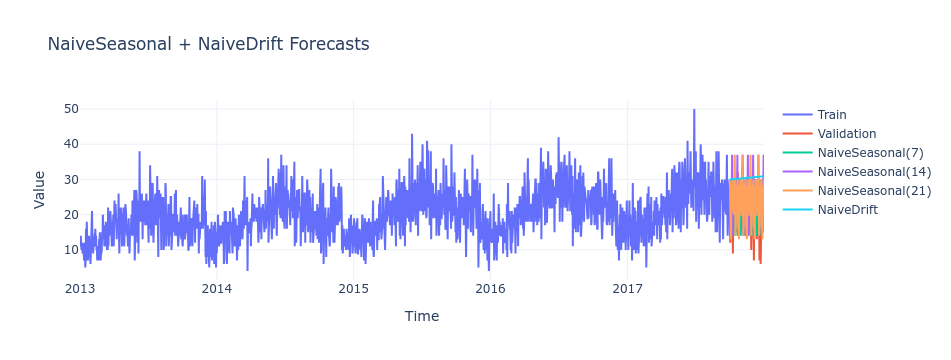

In [14]:
plot_forecasts(
    train=train,       # Darts TimeSeries
    val=val,           # Darts TimeSeries
    preds=preds,       # dict of Darts TimeSeries predictions
    title="NaiveSeasonal + NaiveDrift Forecasts"
)

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

### Conclusions

- NaiveSeasonal(K=21) performed best: MAE ≈ 5.88, MAPE ≈ 37.5%

- NaiveDrift much worse: MAE ≈ 10.4, MAPE ≈ 68.7%

- Indicates strong 3-week seasonal cycle.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [15]:
print("Train length:", len(train), "Val length (horizon):", horizon)

Train length: 1734 Val length (horizon): 92


In [16]:
full_index = series_sales.time_index  # DatetimeIndex

cov_df = pd.DataFrame(index=full_index)
cov_df['dayofweek'] = cov_df.index.dayofweek         # 0=Mon..6=Sun
cov_df['day'] = cov_df.index.day
cov_df['month'] = cov_df.index.month
cov_df['weekofyear'] = cov_df.index.isocalendar().week.astype(int)
cov_df['is_weekend'] = cov_df['dayofweek'].isin([5,6]).astype(int)

# Cyclical transforms for periodic features (avoid one-hot explosion)
cov_df['dow_sin'] = np.sin(2 * np.pi * cov_df['dayofweek'] / 7)
cov_df['dow_cos'] = np.cos(2 * np.pi * cov_df['dayofweek'] / 7)
cov_df['month_sin'] = np.sin(2 * np.pi * (cov_df['month']-1) / 12)
cov_df['month_cos'] = np.cos(2 * np.pi * (cov_df['month']-1) / 12)
cov_df['woy_sin'] = np.sin(2 * np.pi * cov_df['weekofyear'] / 52)
cov_df['woy_cos'] = np.cos(2 * np.pi * cov_df['weekofyear'] / 52)

# Optionally standardize numeric covariates 
covariate_cols = ['dow_sin','dow_cos','month_sin','month_cos','woy_sin','woy_cos','is_weekend','day','weekofyear']
# scale day and weekofyear to ~[0,1]
cov_df['day'] = (cov_df['day'] - cov_df['day'].min()) / (cov_df['day'].max() - cov_df['day'].min())
cov_df['weekofyear'] = (cov_df['weekofyear'] - 1) / 52.0

# pick final columns
cov_df = cov_df[covariate_cols]

# Convert covariates to darts TimeSeries
cov_ts = TimeSeries.from_dataframe(cov_df)  

cov_train = cov_ts.slice_intersect(train)  # covariates aligned with train
cov_full_for_pred = cov_ts  

In [17]:
#  Build XGBModel
model = XGBModel(
    lags=list(range(-21, 0)),                 # past lags of target
    lags_past_covariates=list(range(-21, 0)), # past lags of covariates
    output_chunk_length=1,
    n_estimators=200,
    random_state=42
)

In [18]:
model.fit(series=train, past_covariates=cov_train)

XGBModel(lags=[-21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_past_covariates=[-21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=200)

In [19]:
pred_xgb = model.predict(n=len(val), past_covariates=cov_full_for_pred)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [20]:
#  Evaluate
mae_xgb = mae(val, pred_xgb)
mape_xgb = mape(val, pred_xgb)

In [21]:
results_df = pd.DataFrame(columns=['model', 'MAE', 'MAPE_pct']).set_index('model')

mae_naive21, mape_naive21, forecast_naive21 = fit_eval_model(NaiveSeasonal(K=21), "NaiveSeasonal21", train, val)
results_df = append_results(results_df, "NaiveSeasonal21", mae_naive21, mape_naive21)
results_df = append_results(results_df,'XGBModel', mae_xgb, mape_xgb)

print(results_df)

NaiveSeasonal21 -> MAE: 5.8804, MAPE: 37.54%
                      MAE   MAPE_pct
model                               
NaiveSeasonal21  5.880435  37.543266
XGBModel         4.606968  25.146428


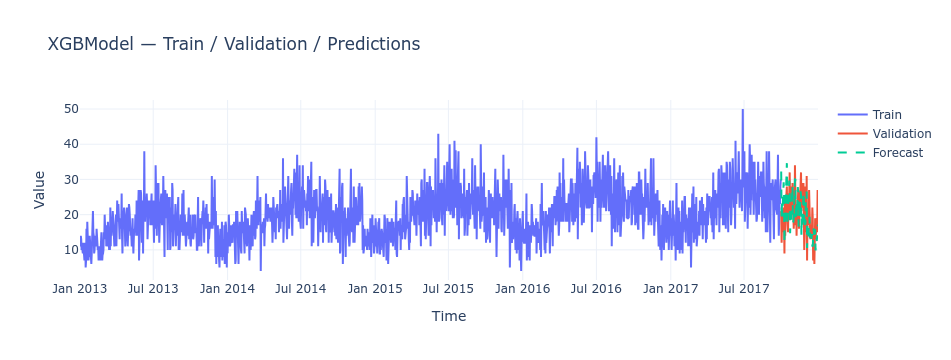

In [22]:
plot_forecasts(
    train=train,        
    val=val,            
    preds=pred_xgb,     
    title="XGBModel — Train / Validation / Predictions"
)

### Conclusions

1. The XGBModel significantly outperforms the naive seasonal benchmark — MAPE drops from ~37.5% to ~25%.

2. This improvement shows that the model successfully captures:

- non-linear relationships,  
- interactions with date features (day-of-week, month, week-of-year, weekend flag),  
- and seasonal patterns up to 3 weeks (via lags).

3. NaiveSeasonal(21) only repeats past seasonal patterns, ignoring finer trends or calendar interactions, which is why its error is higher.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [23]:
mae_es, mape_es, forecast_es = fit_eval_model(ExponentialSmoothing(), "ExponentialSmoothing", train, val)
results_df = append_results(results_df, "ExponentialSmoothing", mae_es, mape_es)
results_df 

ExponentialSmoothing -> MAE: 5.7073, MAPE: 39.01%


,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841


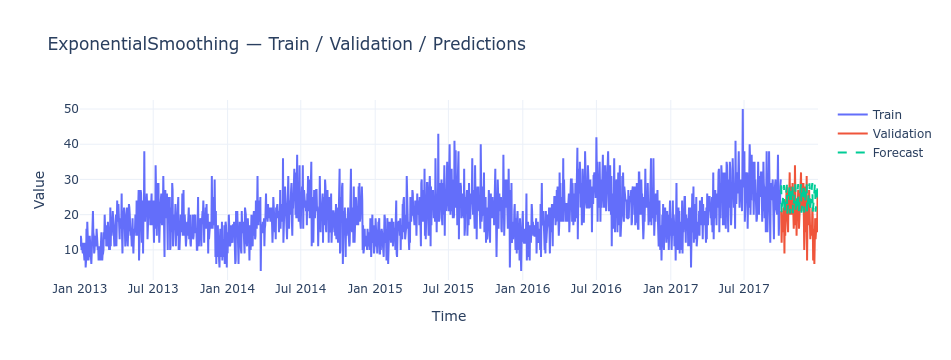

In [24]:
plot_forecasts(
    train=train,        
    val=val,            
    preds=forecast_es,     
    title="ExponentialSmoothing — Train / Validation / Predictions"
)

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [25]:
mae_arima, mape_arima, forecast_arima= fit_eval_model(ARIMA(), "ARIMA", train, val)
results_df = append_results(results_df, "ARIMA", mae_arima, mape_arima)

ARIMA -> MAE: 5.7762, MAPE: 39.49%


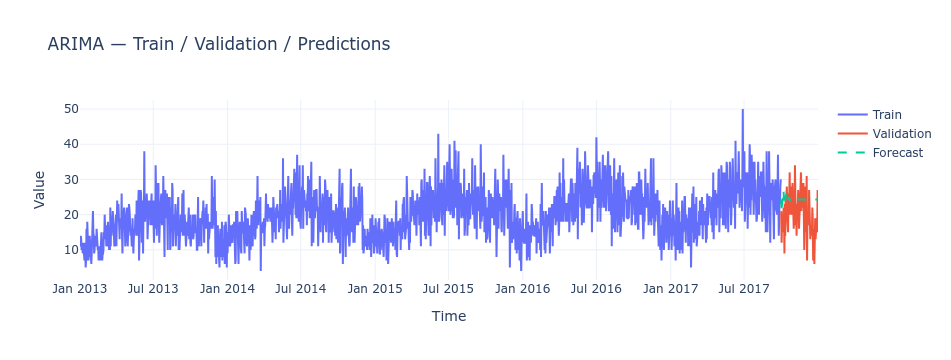

In [26]:
plot_forecasts(
    train=train,        
    val=val,            
    preds=forecast_arima,     
    title="ARIMA — Train / Validation / Predictions"
)

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [27]:
def find_optimal_arima_darts(train_ts, val_ts, seasonal, seasonal_period):
    warnings.filterwarnings('ignore', category=UserWarning)
    try:
        model = AutoARIMA(
            start_p=0, start_q=0, max_p=6, max_q=6,
            start_P=0, start_Q=0, max_P=3, max_Q=3,
            seasonal=seasonal, season_length=seasonal_period if seasonal else 1,
            stepwise=True, trace=True
        )
        model.fit(train_ts)
        
    except Exception as e:
        print(f"Error {e}")
        print("Simple Search")
        model = AutoARIMA(
            start_p=1, start_q=1, max_p=3, max_q=3,
            seasonal=False, stepwise=True
        )
        model.fit(train_ts)
    
    forecast = model.predict(len(val_ts))
    
    mae_val = mae(val_ts, forecast)
    mape_val = mape(val_ts, forecast)
    rmse_val = rmse(val_ts, forecast)
    
    print("AutoARIMA")
    print(f"MAE: {mae_val:.4f}, RMSE: {rmse_val:.4f}, MAPE: {mape_val:.2f}%")
    
    return {
        'model': model,
        'forecast':forecast,
        'metrics': {'mae': mae_val, 'rmse': rmse_val, 'mape': mape_val}
    }

In [28]:
results = find_optimal_arima_darts(train, val, seasonal=True, seasonal_period=7)

best_mae = results['metrics']['mae']
best_mape = results['metrics']['mape']

print(f"Best ARIMA Model found with MAE: {best_mae:.4f}")
print(f"Best ARIMA Model found with MAPE: {best_mape:.2f}%")


ARIMA(0,1,0) with drift        :11699.318946383404

ARIMA(0,1,0) with drift        :11699.318946383404

ARIMA(1,1,0)(1,0,0)[7] with drift        :11207.06550013974

ARIMA(0,1,1)(0,0,1)[7] with drift        :10659.54083761185

ARIMA(0,1,0)                   :11697.3176603854

ARIMA(0,1,1) with drift        :10763.389108968566

ARIMA(0,1,1)(1,0,1)[7] with drift        :inf

ARIMA(0,1,1)(0,0,2)[7] with drift        :10587.221751657391

ARIMA(0,1,1)(1,0,2)[7] with drift        :inf

ARIMA(0,1,1)(0,0,3)[7] with drift        :10556.390862542907

ARIMA(0,1,1)(1,0,3)[7] with drift        :inf

ARIMA(0,1,0)(0,0,3)[7] with drift        :11535.679429345348

ARIMA(1,1,1)(0,0,3)[7] with drift        :10551.735056920596

ARIMA(1,1,1)(0,0,2)[7] with drift        :10580.668461802417

ARIMA(1,1,1)(1,0,3)[7] with drift        :inf

ARIMA(1,1,1)(1,0,2)[7] with drift        :inf

ARIMA(1,1,0)(0,0,3)[7] with drift        :11155.902910957946

ARIMA(2,1,1)(0,0,3)[7] with drift        :10551.002766479276

AR

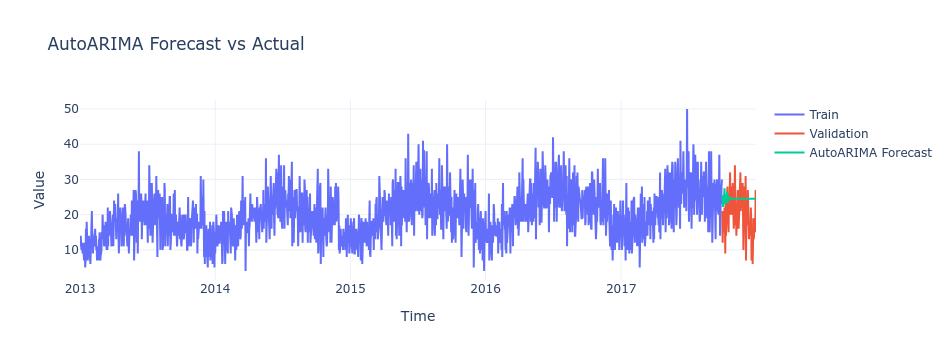

In [29]:
best_model = results['model']
forecast_ts = best_model.predict(len(val))

plot_forecasts(
    train=train,
    val=val,
    preds={'AutoARIMA Forecast': forecast_ts},
    title="AutoARIMA Forecast vs Actual"
)

In [30]:
results_df = append_results(results_df, "AutoARIMA", results['metrics']['mae'], results['metrics']['mape'])
results_df

,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841
ARIMA,5.776212,39.492251
AutoARIMA,5.901517,40.440003


14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [31]:
train_prophet = pd.DataFrame({
    'ds': train.time_index,        
    'y': train.values().flatten()
})

val_prophet = pd.DataFrame({
    'ds': val.time_index,
    'y': val.values().flatten()
})

In [32]:
# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_prophet)

# Forecast for validation period
future = val_prophet[['ds']].copy()
forecast = model.predict(future)

# Extract predictions and true values
y_pred = forecast['yhat'].values
y_true = val_prophet['y'].values

mae_prophet = mean_absolute_error(y_true, y_pred)
mape_prophet = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results_df = append_results(results_df, "Prophet", mae_prophet, mape_prophet)
results_df

16:01:30 - cmdstanpy - INFO - Chain [1] start processing
16:01:30 - cmdstanpy - INFO - Chain [1] done processing


,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841
ARIMA,5.776212,39.492251
AutoARIMA,5.901517,40.440003
Prophet,5.334942,36.402902


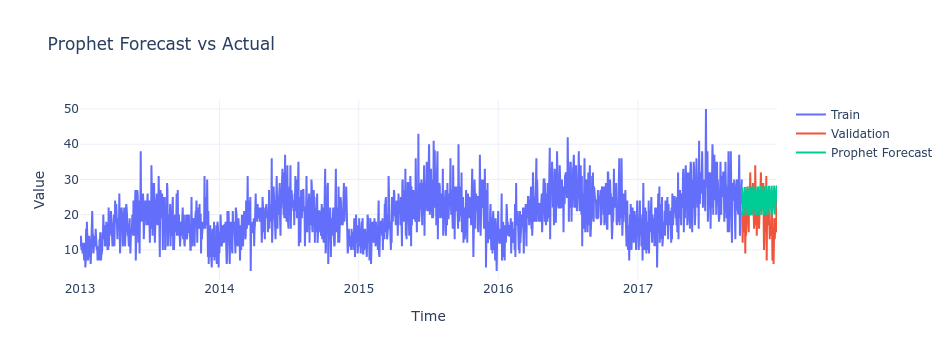

In [33]:
train_ts = TimeSeries.from_dataframe(train_prophet, time_col='ds', value_cols='y')
val_ts = TimeSeries.from_dataframe(val_prophet, time_col='ds', value_cols='y')
forecast_ts = TimeSeries.from_dataframe(forecast, time_col='ds', value_cols='yhat')

plot_forecasts(
    train=train_ts,
    val=val_ts,
    preds={'Prophet Forecast': forecast_ts},
    title="Prophet Forecast vs Actual"
)


15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [34]:
# Ensure input_chunk_length and training_length fit the series
input_chunk_length = max(1, min(12, len(train)-1))
training_length = max(input_chunk_length, min(20, len(train)))
batch_size = min(32, len(train) - input_chunk_length)  # safe batch size

model = RNNModel(
    model='LSTM',
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    input_chunk_length=input_chunk_length,
    training_length=training_length,
    batch_size=batch_size,
    n_epochs=50,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42
)

# Fit & evaluate
model.fit(train)
forecast = model.predict(len(val))
y_true = val.values().flatten()
y_pred = forecast.values().flatten()

mae_rnn = mae_metric(val, forecast)
mape_rnn = mape_metric(val, forecast)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [35]:
results_df = append_results(results_df, "LSTM_RNN", mae_rnn, mape_rnn)
print(results_df)
print(f"input_chunk_length: {input_chunk_length}, training_length: {training_length}, batch_size: {batch_size}")

                           MAE   MAPE_pct
model                                    
NaiveSeasonal21       5.880435  37.543266
XGBModel              4.606968  25.146428
ExponentialSmoothing  5.707340  39.012841
ARIMA                 5.776212  39.492251
AutoARIMA             5.901517  40.440003
Prophet               5.334942  36.402902
LSTM_RNN              4.632469  28.645416
input_chunk_length: 12, training_length: 20, batch_size: 32


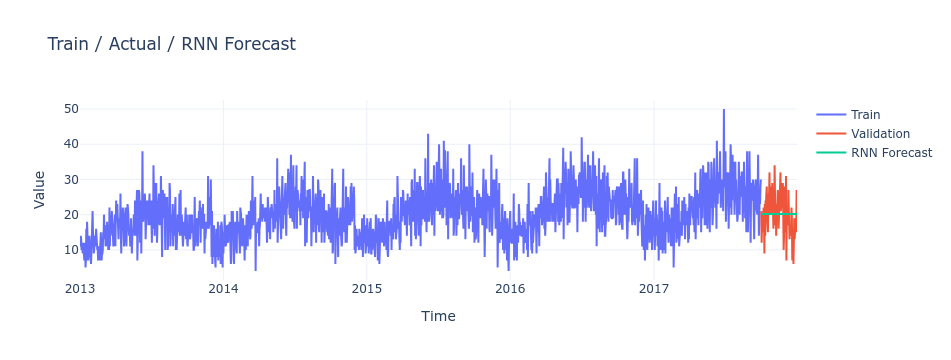

In [36]:
plot_forecasts(
    train=train,
    val=val,
    preds={'RNN Forecast': forecast},
    title="Train / Actual / RNN Forecast"
)

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

- XGBModel outperforms all other methods.

- AutoARIMA improves over simple ARIMA.

- LSTM required careful tuning and epochs; still slightly worse than XGB.

In [37]:
# Forecast horizon and backtest period
forecast_horizon = 30  # 1 month ahead 
backtest_period = 365   # last 1 year for backtest

# Initialize model
model = XGBModel(
    lags=7,         
    n_estimators=100,
    random_state=42
)

# Perform historical forecasts (backtest)
backtest_forecast = model.historical_forecasts(
    series=train,
    start=len(train)-backtest_period,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,  
    retrain=True,
    verbose=True
)

# Actual values for comparison
actual = train[-backtest_period:]

# Calculate backtest metrics
mae_backtest = mae_metric(actual, backtest_forecast)
mape_backtest = mape_metric(actual, backtest_forecast)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

In [38]:
print(f"XGBModel Backtest Accuracy:")
print(f"MAE: {mae_backtest:.4f}, MAPE: {mape_backtest:.2f}%")
results_df = append_results(results_df, "XGBModel_backtest", mae_backtest, mape_backtest)
results_df

XGBModel Backtest Accuracy:
MAE: 9.3681, MAPE: 32.77%


,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841
ARIMA,5.776212,39.492251
AutoARIMA,5.901517,40.440003
Prophet,5.334942,36.402902
LSTM_RNN,4.632469,28.645416
XGBModel_backtest,9.368131,32.771414


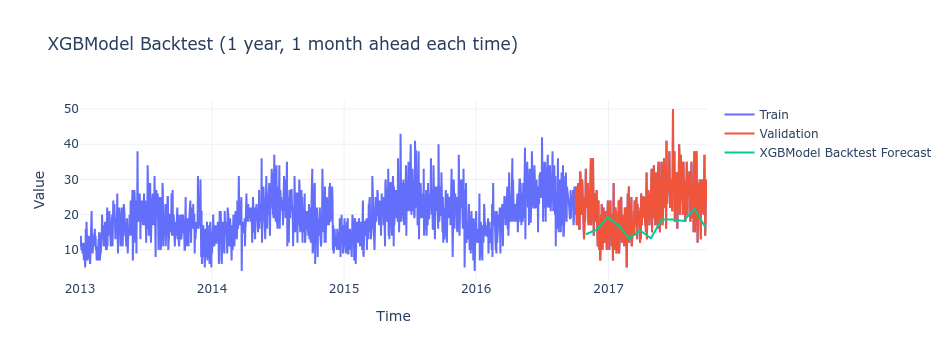

In [39]:
if isinstance(backtest_forecast, list):
    backtest_forecast = reduce(lambda a, b: a.concatenate(b), backtest_forecast)
 
plot_forecasts(
    train=train,
    val=actual,
    preds={'XGBModel Backtest Forecast': backtest_forecast},
    title="XGBModel Backtest (1 year, 1 month ahead each time)"
)

In [40]:
best_params, best_score, best_model = simple_grid_search(
    train_data=train,
    val_data=val,
    covariates_train=cov_train, 
    covariates_full_for_pred=cov_ts, 
    max_trials=50
)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Starting Simple Grid Search...
Testing 50 parameter combinations...
New best score: 4.6393 with params: {'lags': 7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

New best score: 4.6391 with params: {'lags': 7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Completed 10/50 combinations


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Completed 20/50 combinations


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

New best score: 4.5220 with params: {'lags': 14, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Completed 30/50 combinations


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


New best score: 4.4267 with params: {'lags': 14, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.15}


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


New best score: 4.3303 with params: {'lags': 14, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Completed 40/50 combinations


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_

Completed 50/50 combinations
Grid Search Complete!
Best MAE: 4.3303
Best parameters: {'lags': 14, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}


In [41]:
# Forecast horizon and backtest period
forecast_horizon = 30   # 1 month ahead
backtest_period = 365   # last 1 year for backtest

# Initialize model with best parameters
model = XGBModel(
    lags=best_params['lags'],             # tuned lag length
    n_estimators=best_params['n_estimators'],    # tuned number of trees
    max_depth=best_params['max_depth'],         # tuned tree depth
    learning_rate=best_params['learning_rate'],   # tuned learning rate
    random_state=42
)

# Perform historical forecasts (backtest)
backtest_forecast = model.historical_forecasts(
    series=train,
    start=len(train)-backtest_period,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,   # forecast in 1-month steps
    retrain=True,
    verbose=True,
    last_points_only=False
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

In [42]:
# Actual values for comparison
actual = train[-backtest_period:]

mae_list = []
mape_list = []

# iterate over forecast windows
for i in range(len(backtest_forecast)):
    start_idx = i * forecast_horizon
    end_idx = start_idx + forecast_horizon
    y_true = actual[start_idx:end_idx].values()
    y_pred = backtest_forecast[i].values()  # each forecast is a TimeSeries
    mae_list.append(mean_absolute_error(y_true, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_true, y_pred))

# Average across all windows
mae_backtest = np.mean(mae_list)
mape_backtest = np.mean(mape_list)

print("Backtest MAE:", mae_backtest)
print("Backtest MAPE:", mape_backtest)

results_df = append_results(results_df, "XGBModel_backtest_tuned", mae_backtest, mape_backtest)
results_df

Backtest MAE: 4.796189170413547
Backtest MAPE: 0.24061156620302115


,MAE,MAPE_pct
model,,
NaiveSeasonal21,5.880435,37.543266
XGBModel,4.606968,25.146428
ExponentialSmoothing,5.707340,39.012841
ARIMA,5.776212,39.492251
AutoARIMA,5.901517,40.440003
Prophet,5.334942,36.402902
LSTM_RNN,4.632469,28.645416
XGBModel_backtest,9.368131,32.771414
XGBModel_backtest_tuned,4.796189,0.240612


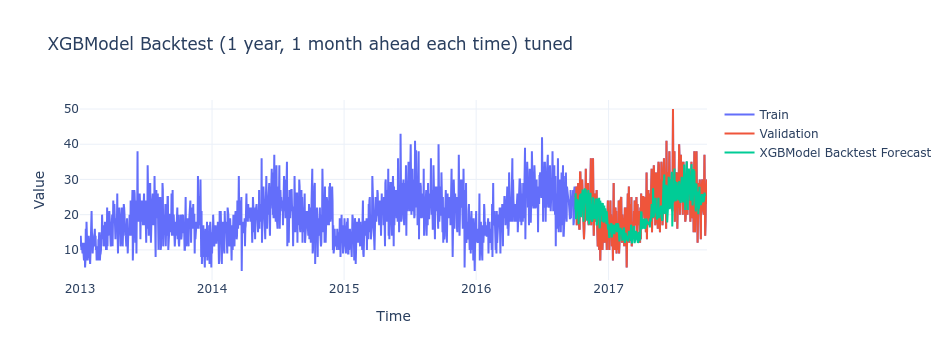

In [43]:
if isinstance(backtest_forecast, list):
    backtest_forecast = reduce(lambda a, b: a.concatenate(b), backtest_forecast)
 
plot_forecasts(
    train=train,
    val=actual,
    preds={'XGBModel Backtest Forecast': backtest_forecast},
    title="XGBModel Backtest (1 year, 1 month ahead each time) tuned"
)

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

### Scaling to All Items & Stores

**Approach:** Global model (one model for all 500 series: 50 items × 10 stores, for example XGBModel)

**Features:**

- Lags (1, 7, 14, 30)

- Rolling means (7, 14, 30 days)

- Calendar: day-of-week, month, holidays, weekend flag

- Item/store IDs

- Business: promotions, prices

**Validation:** Backtest with 30-day horizon, stride=30

**Deployment:** Retrain weekly/monthly, monitor per-series error

**Advantages of global model:**

- Efficient (train 1 model vs 500 local models)

- Learns shared seasonal and trend patterns

- Easier to maintain & deploy

- Optional: separate local models for intermittent/sparse items.

### Summary

1. Best model for single item: XGBModel with date features & lags

2. Global scaling: 1–3 models for all items/stores, using global learning

3. Metrics: MAE, MAPE